Validation will begin with the SIM_BIG_WAREHOUSE_5AM_NO_REBAL simulation, and compare the behaviour with the real-life BSS

In [1]:
from pathlib import Path
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
import os

In [2]:
# work from the project root
if os.getcwd().endswith('notebooks'):
    os.chdir("..")

In [3]:
db = sqlite3.connect(Path('tfl_project/data/bike_db.db'))

In [6]:
sim_out_dir = Path('tfl_project/data/simulation_outputs/SIM1_BIG_WAREHOUSE_5AM_NO_REBAL')
sim_event_loc = sim_out_dir / 'events.csv'
sim_ts_loc = sim_out_dir / 'time_series.csv'

In [7]:
sim_event_df = pd.read_csv(sim_event_loc)
sim_ts_df = pd.read_csv(sim_ts_loc)

## Simulation Behaviour

In [8]:
sim_event_df.head()

,time,start_st,end_st,orig_start_st,orig_end_st,event,simulation_id,sim_num
0,3,239,81,239,81,finished_journeys,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0
1,5,74,267,74,267,finished_journeys,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0
2,6,123,798,123,798,finished_journeys,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0
3,6,20,425,20,425,finished_journeys,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0
4,6,467,468,467,468,finished_journeys,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0


In [9]:
sim_ts_df.head()

,time,failed_starts,failed_ends,finished_journeys,simulation_id,sim_num
0,0,0,0,0,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0
1,1,0,0,0,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0
2,2,0,0,0,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0
3,3,0,0,1,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0
4,4,0,0,0,SIM1_BIG_WAREHOUSE_5AM_NO_REBAL,0


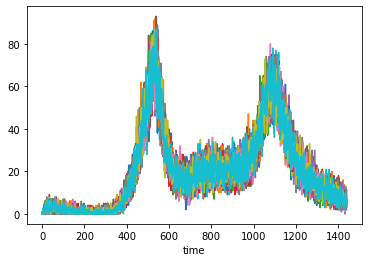

In [10]:
sim_ts_df.pivot_table('finished_journeys', 'time', 'sim_num').plot(legend=False)

## Reality in 2019

In [61]:
# This fetches minute-ly data which we'll down-sample
fin_journeys_2019 = pd.read_sql_query("""
    SELECT
        time
        ,AVG(finished_journeys) AS mean_finished_journeys
    FROM (
        SELECT
            CAST(strftime('%j', "End Date") AS INT) AS day_of_year
            ,strftime('%H',"End Date")*60 + strftime('%M',"End Date") AS time
            ,COUNT(*) AS finished_journeys
        FROM
            journeys
        WHERE
            year = 2019
            AND weekday_ind = 1
        GROUP BY 1,2
        )
    GROUP BY 1
    ORDER BY 1
    """, db)

In [65]:
fin_journeys_2019.set_index('time', inplace=True)

## Comparison

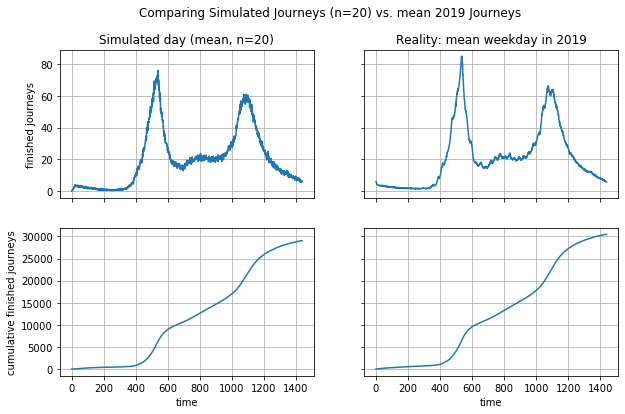

In [210]:
stgb = sim_ts_df.groupby('time')['finished_journeys']
fig, ax = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10,6))

# Non-cumulative Journeys
## Simulated
stgb.mean().plot(ax=ax[0][0], grid=True)
## 2019
fin_journeys_2019.plot(ax=ax[0][1], grid=True)

# Cumulaative
## Simulated
stgb.mean().cumsum().plot(ax=ax[1][0], grid=True)
## 2019
fin_journeys_2019.cumsum().plot(ax=ax[1][1], grid=True)

fig.suptitle('Comparing Simulated Journeys (n=20) vs. mean 2019 Journeys')
ax[0][0].set_title('Simulated day (mean, n=20)')
ax[0][0].set_ylabel('finished journeys')
ax[0][1].set_title('Reality: mean weekday in 2019')
ax[0][1].get_legend().remove()
ax[1][0].set_ylabel('cumulative finished journeys')
ax[1][1].get_legend().remove()

plt.savefig('sim_validation_timeline.png',dpi=300);

## Scatter of Journeys

In [146]:
def sim_station_journeys(direction, time):
    if time == 'AM':
        sub = sim_event_df[sim_event_df['time']<=720]
    elif time == 'PM':
        sub = sim_event_df[sim_event_df['time']>720]
    else:
        sub = sim_event_df
    
    if direction == 'arrivals':
        st = 'end_st'
        name = 'avg_simulation_arrivals'
    elif direction == 'departures':
        st = 'start_st'
        name = 'avg_simulation_departures'
        
    series = sub.groupby([st,'sim_num']).size().groupby(st).mean()
    series.rename(name, inplace=True)
    
    return series

In [147]:
# sim_avg_arrivals = sim_event_df.groupby(['end_st','sim_num']).size().groupby('end_st').mean()
# sim_avg_arrivals.rename('avg_simulation_arrivals', inplace=True)
# sim_avg_departures = sim_event_df.groupby(['start_st','sim_num']).size().groupby('start_st').mean()
# sim_avg_departures.rename('avg_simulation_departures', inplace=True)

In [155]:
avg_arrivals_2019_am = pd.read_sql_query("""
    SELECT
        "EndStation Id"
        ,AVG(finished_journeys) AS avg_2019_arrivals
    FROM (
        SELECT
            CAST(strftime('%j', "End Date") AS INT) AS day_of_year
            ,"EndStation Id"
            ,COUNT(*) AS finished_journeys
        FROM
            journeys
        WHERE
            year = 2019
            AND weekday_ind = 1
            AND "EndStation Id" != -1
            AND CAST(strftime('%H',"End Date") AS INT) < 12
        GROUP BY 1,2
        )
    GROUP BY 1
    ORDER BY 1
    """, db)

# This fetches minute-ly data which we'll down-sample
avg_departures_2019_am = pd.read_sql_query("""
    SELECT
        "StartStation Id"
        ,AVG(finished_journeys) AS avg_2019_departures
    FROM (
        SELECT
            CAST(strftime('%j', "Start Date") AS INT) AS day_of_year
            ,"StartStation Id"
            ,COUNT(*) AS finished_journeys
        FROM
            journeys
        WHERE
            year = 2019
            AND weekday_ind = 1
            AND "StartStation Id" != -1
            AND CAST(strftime('%H',"Start Date") AS INT) < 12
        GROUP BY 1,2
        )
    GROUP BY 1
    ORDER BY 1
    """, db)

avg_arrivals_2019_pm = pd.read_sql_query("""
    SELECT
        "EndStation Id"
        ,AVG(finished_journeys) AS avg_2019_arrivals
    FROM (
        SELECT
            CAST(strftime('%j', "End Date") AS INT) AS day_of_year
            ,"EndStation Id"
            ,COUNT(*) AS finished_journeys
        FROM
            journeys
        WHERE
            year = 2019
            AND weekday_ind = 1
            AND "EndStation Id" != -1
            AND CAST(strftime('%H',"End Date") AS INT) >= 12
        GROUP BY 1,2
        )
    GROUP BY 1
    ORDER BY 1
    """, db)

# This fetches minute-ly data which we'll down-sample
avg_departures_2019_pm = pd.read_sql_query("""
    SELECT
        "StartStation Id"
        ,AVG(finished_journeys) AS avg_2019_departures
    FROM (
        SELECT
            CAST(strftime('%j', "Start Date") AS INT) AS day_of_year
            ,"StartStation Id"
            ,COUNT(*) AS finished_journeys
        FROM
            journeys
        WHERE
            year = 2019
            AND weekday_ind = 1
            AND "StartStation Id" != -1
            AND CAST(strftime('%H',"Start Date") AS INT) >= 12
        GROUP BY 1,2
        )
    GROUP BY 1
    ORDER BY 1
    """, db)

In [156]:
avg_arrivals_2019_am.set_index('EndStation Id', inplace=True)
avg_arrivals_2019_pm.set_index('EndStation Id', inplace=True)
avg_departures_2019_am.set_index('StartStation Id', inplace=True)
avg_departures_2019_pm.set_index('StartStation Id', inplace=True)

In [157]:
arrivals_merged_am = pd.merge(sim_station_journeys('arrivals', 'AM')
                              , avg_arrivals_2019_am
                              , how='outer', left_index=True, right_index=True)

arrivals_merged_pm = pd.merge(sim_station_journeys('arrivals', 'PM')
                              , avg_arrivals_2019_pm
                              , how='outer', left_index=True, right_index=True)

departures_merged_am = pd.merge(sim_station_journeys('departures', 'AM')
                              , avg_departures_2019_am
                              , how='outer', left_index=True, right_index=True)

departures_merged_pm = pd.merge(sim_station_journeys('departures', 'PM')
                              , avg_departures_2019_pm
                              , how='outer', left_index=True, right_index=True)

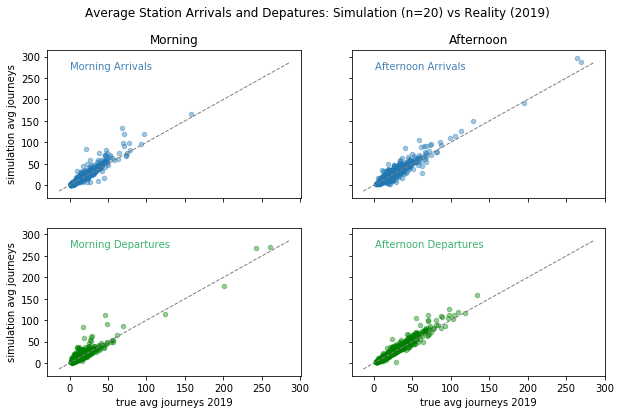

In [213]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,6))

xarr='avg_2019_arrivals'
yarr='avg_simulation_arrivals'
xdep='avg_2019_departures'
ydep='avg_simulation_departures'

# Morning
arrivals_merged_am.plot(x=xarr, y=yarr, kind='scatter', alpha=0.4, ax=ax[0][0])
departures_merged_am.plot(x=xdep, y=ydep, kind='scatter', alpha=0.4, ax=ax[1][0], color='green')
# Afternoon
arrivals_merged_pm.plot(x=xarr, y=yarr, kind='scatter', alpha=0.4, ax=ax[0][1])
departures_merged_pm.plot(x=xdep, y=ydep, kind='scatter', alpha=0.4, ax=ax[1][1], color='green')

fig.suptitle('Average Station Arrivals and Depatures: Simulation (n=20) vs Reality (2019)')

ax[0][0].set_title('Morning')
ax[0][1].set_title('Afternoon')

# fig.text(0.5, 0.04, 'Real Daily Journeys in 2019 (daily avg)', ha='center')
# fig.text(0.06, 0.5, 'Simulated Journeys (avg n=20)', va='center', rotation='vertical')
x0,x1 = ax[0][0].get_xlim()
y0,y1 = ax[0][0].get_ylim()

for _ in ax:
    for ax_i in _:
        ax_i.plot([x0,x1], [x0, x1], color='grey', linestyle='--', linewidth='1')

ax[0][0].set_ylabel('simulation avg journeys')
ax[1][0].set_ylabel('simulation avg journeys')
ax[1][0].set_xlabel('true avg journeys 2019')
ax[1][1].set_xlabel('true avg journeys 2019')

ax[0][0].text(1, 270, 'Morning Arrivals', color='steelblue')
ax[0][1].text(1, 270, 'Afternoon Arrivals', color='steelblue')
ax[1][0].text(1, 270, 'Morning Departures', color='mediumseagreen')
ax[1][1].text(1, 270, 'Afternoon Departures', color='mediumseagreen');

plt.savefig('sim_validation_scatter.png',dpi=300);